# Image Preprocessing

Testing image preprocessing routines.

In [34]:
# importing 
import h5py
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter

In [18]:
path = "../../deepscribe-data/processed/pfa_new/a_pfa.h5"

f = h5py.File(path, 'r')

print("Loaded dataset from {} with {} unique signs".format(path, len(f.keys())))

Loaded dataset from ../../deepscribe-data/processed/pfa_new/a_pfa.h5 with 278 unique signs


In [19]:
test_sign = '1'

group = f[test_sign]
print("{} examples of sign {}".format(len(group.keys()), test_sign))

2743 examples of sign 1


dataset attributes: 
 type (111, 90) 
 shape uint8 



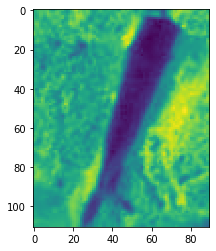

In [20]:
test_indx = list(group.keys())[60]

dset = group[test_indx]
print("dataset attributes: \n type {} \n shape {} \n".format(dset.shape, dset.dtype))
# get numpy array
dset_numpy = dset[()]


plt.imshow(dset_numpy)


-2.0939317458235583e-15
33.56144045180593


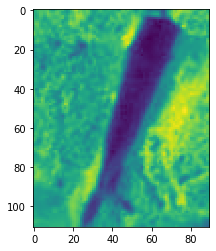

In [29]:
# testing - centering vs standardization

dset_centered = dset_numpy - np.mean(dset_numpy)
print(np.mean(dset_centered))
print(np.std(dset_centered))

plt.imshow(dset_centered)

-9.104051068798081e-17


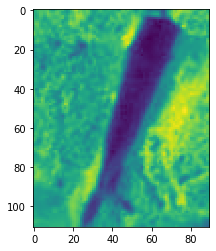

In [27]:

dset_standardized = (dset_numpy - np.mean(dset_numpy))/np.std(dset_numpy)

print(np.mean(dset_standardized))


plt.imshow(dset_standardized)

In [77]:
# testing padding

def resize(img, target_size):
    old_size = img.shape[:2]  # old_size is in (height, width) format
    # computes
    ratio = float(target_size) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])
    # new_size should be in (width, height) format
    img = cv2.resize(img, (new_size[1], new_size[0]))
    
    return img

def pad_img(img, target_size):
    old_size = img.shape[:2]  # old_size is in (height, width) format
    # computes
    ratio = float(target_size) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])
    # new_size should be in (width, height) format
    img = cv2.resize(img, (new_size[1], new_size[0]))
    delta_w = int(target_size) - new_size[1]
    delta_h = int(target_size) - new_size[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    # filtering here before padding! otherwise, filter will be applied to the border as well.

    img_filtered = gaussian_filter(img, sigma=0.5)

    new_im = cv2.copyMakeBorder(
        img_filtered, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0
    )

    return new_im

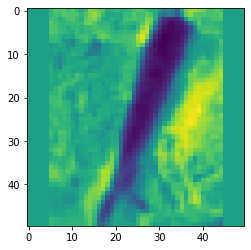

In [51]:
plt.imshow(pad_img(dset_centered, 50))

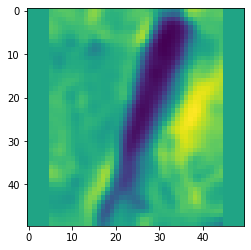

In [45]:
plt.imshow(pad_img(dset_standardized, 50))

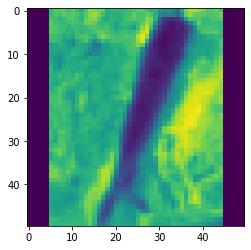

In [53]:
# padding and THEN normalized

padded_original = pad_img(dset_numpy, 50)
plt.imshow(padded_original)

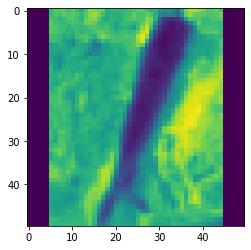

In [54]:
padded_standardized = (padded_original - np.mean(padded_original))/np.std(padded_original)

plt.imshow(padded_standardized)

# Testing: Histogram Equalization

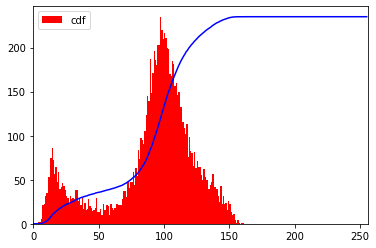

In [67]:
# copy image and convert to grayscale 

# make image histogram
hist,bins = np.histogram(dset_numpy.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

plt.hist(dset_numpy.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.plot(cdf_normalized, color = 'b')

# simple histogram equalization
equalized = cv2.equalizeHist(dset_numpy)

# new histogram

# hist,bins = np.histogram(equalized.flatten(),256,[0,256])

# cdf = hist.cumsum()
# cdf_normalized = cdf * hist.max()/ cdf.max()
# plt.hist(equalized.flatten(),256,[0,256], color = 'r')
# plt.xlim([0,256])
# plt.legend(('cdf','histogram'), loc = 'upper left')
# plt.plot(cdf_normalized, color = 'b')




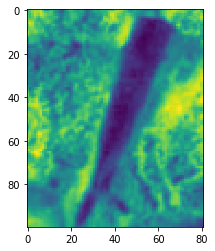

In [81]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(dset_numpy)
plt.imshow(resize(cl1, 100))

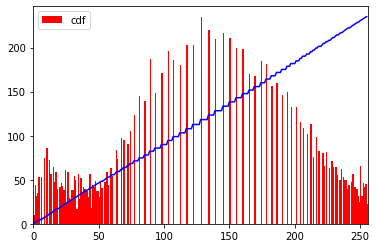

In [70]:
hist,bins = np.histogram(equalized.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()
plt.hist(equalized.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.plot(cdf_normalized, color = 'b')

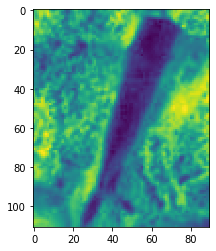

In [69]:
# adaptive histogram

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(dset_numpy)
plt.imshow(cl1)

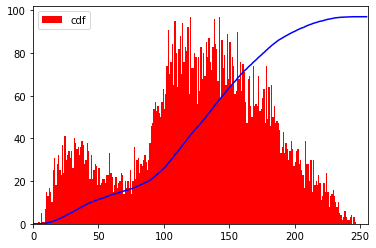

In [72]:
hist,bins = np.histogram(cl1.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()
plt.hist(cl1.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.plot(cdf_normalized, color = 'b')

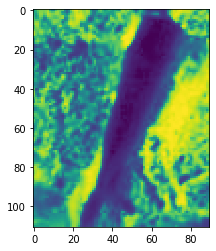

In [71]:
plt.imshow(equalized)

# Testing: Otsu Thresholding

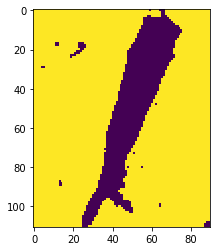

In [55]:
# otsu thresholding on original image

ret1, thresh1 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(thresh1)

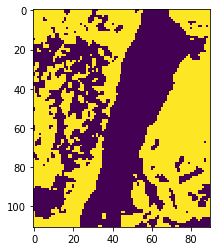

In [56]:
# otsu thresholding on equalized image

ret2, thresh2 = cv2.threshold(equalized, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.imshow(thresh2)

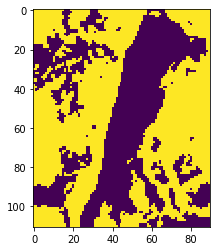

In [57]:
# otsu thresholding on adaptive equalized image

ret3, thresh3 = cv2.threshold(cl1, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.imshow(thresh3)

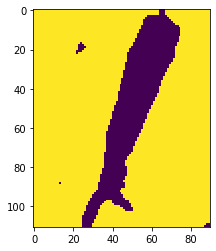

In [59]:
# otsu thresholding with gaussian blur

blur = cv2.GaussianBlur(img,(5,5),0)
ret4, thresh4 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.imshow(thresh4)

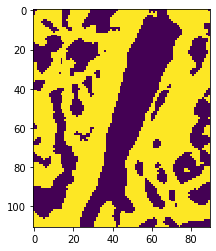

In [65]:
# adaptive thresholding with gaussian blur
blur2 = cv2.medianBlur(img,5)
th5 = cv2.adaptiveThreshold(blur2,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,51,2)

plt.imshow(th5)